In [1]:

from template_match import read_image_rgb, read_image_gray, template_match, \
    detect_points, find_tolerance_limit, simplify_points, point_to_bbox, agglomerative_clustering, meanshift_clustering, \
    invert_convolution_map

from process_template import template_tresholding, extract_largest_component, find_bbox, \
    crop_image, frame_image, is_grayscale

from setup_logger import logger

In [2]:
import os
import pathlib
from typing import List, Tuple
from sklearn.cluster import AgglomerativeClustering
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy_indexed as npi
from tqdm.notebook import tqdm

In [3]:
from ipywidgets import interact, widgets
from plotly.express import imshow as imshow_interactive

In [4]:
def draw_image(image: np.ndarray) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))


def draw_points_on_canvas(points: np.ndarray, image: np.ndarray) -> None:
    x = points[:, 0]
    y = points[:, 1]
    
    clear_canvas = image.copy()
    clear_canvas[:, :] = 255
    plt.scatter(x, y, alpha=0.5, s=5)
    plt.imshow(cv.cvtColor(clear_canvas, cv.COLOR_BGR2RGB))


from matplotlib.patches import Rectangle

def draw_bbox(x_min, x_max, y_min, y_max, bbox_center=None) -> None:
    height = y_max - y_min
    width = x_max - x_min
    rect = Rectangle((x_min, y_min), width, height, edgecolor='r', facecolor='none')
    ax = plt.gca()
    ax.add_patch(rect)

    if bbox_center:
        bbox_center_x, bbox_center_y = bbox_center
        plt.scatter([bbox_center_x], [bbox_center_y], marker="*")

In [5]:
def multi_template_match(
    image: np.ndarray,
    templates: List[np.ndarray],
    template_masks: List[np.ndarray],
    method_name: str
) -> Tuple[List[np.ndarray], List[float]]:
    """ 
    Run opencv templateMatch on each template from list of templates.
    Return list of convolution maps and list of maximum values on each map.
    """
    method = eval(method_name)

    convolution_map_list = []
    max_val_list = []

    for template, template_mask in zip(templates, template_masks):

        convolution_map = cv.matchTemplate(image, template, method, mask=template_mask)
        if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED, cv.TM_CCORR]:
            logger.debug(f"Convolution map bounds: {np.min(convolution_map), np.max(convolution_map)}")
            logger.debug("Convolution map was inverted")
            convolution_map = invert_convolution_map(convolution_map)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(convolution_map)

        convolution_map_list.append(convolution_map)
        max_val_list.append(max_val)

    return convolution_map_list, max_val_list

In [6]:
def get_best_matches(convolution_map_list: List[np.ndarray]) -> np.ndarray:
    """
    Idea: At ech pixel of source image find which template gives
            maximum correlation value during template matching process.

    Return 2d array of the same size as convolution map.
    Each array value represents number of template (<=> label) that gives best match at this position. 
    """
    stacked_conv_maps = np.stack(convolution_map_list)

    # best_match_corr_values = np.max(stacked_conv_maps, axis=0)
    best_match_template_numbers = np.argmax(stacked_conv_maps, axis=0)
    return best_match_template_numbers


def detect_points_v2(
    convolution_map: np.ndarray,
    max_value: float,
    tolerance: float,
    best_match_map: np.ndarray,
    template_number: int
) -> np.ndarray:
    
    max_positions = np.where( np.isclose(convolution_map, max_value, atol=tolerance) )
    y, x = max_positions
    max_points = np.array([x, y]).T
    
    allowed_positions = np.where( best_match_map == template_number )

    if len(allowed_positions[0]) == 0:
        logger.warning("Template has not any best matches")
        return max_points

    else:
        y, x = allowed_positions
        points_with_allowed_positions = np.array([x, y]).T
        points = npi.intersection(max_points, points_with_allowed_positions)
        return points

In [7]:
BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

## Multi template matching

In [8]:
PLOT_NUMBER = 11
MARKER_NUMBERS = [1, 2, 3, 4]
MARKER_NUMBERS = np.array(MARKER_NUMBERS)


PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"

TEMPLATE_PATHS = [DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUM}.png"
                  for MARKER_NUM in MARKER_NUMBERS]

In [9]:
# read image
source_image = read_image_rgb(PLOT_PATH)
image_rgb = read_image_rgb(PLOT_PATH)  # here we will add mask


# read all templates
templates = [read_image_rgb(TEMPLATE_PATH) for TEMPLATE_PATH in TEMPLATE_PATHS]

w_list = [template.shape[1] for template in templates]
h_list = [template.shape[0] for template in templates]
w = w_list[0]
h = h_list[0]
for i in range(len(w_list) - 1):
    assert w_list[i] == w_list[i+1], "templates have different shapes"
    assert h_list[i] == h_list[i+1], "templates have different shapes"

Text(0.5, 1.0, 'template 2')

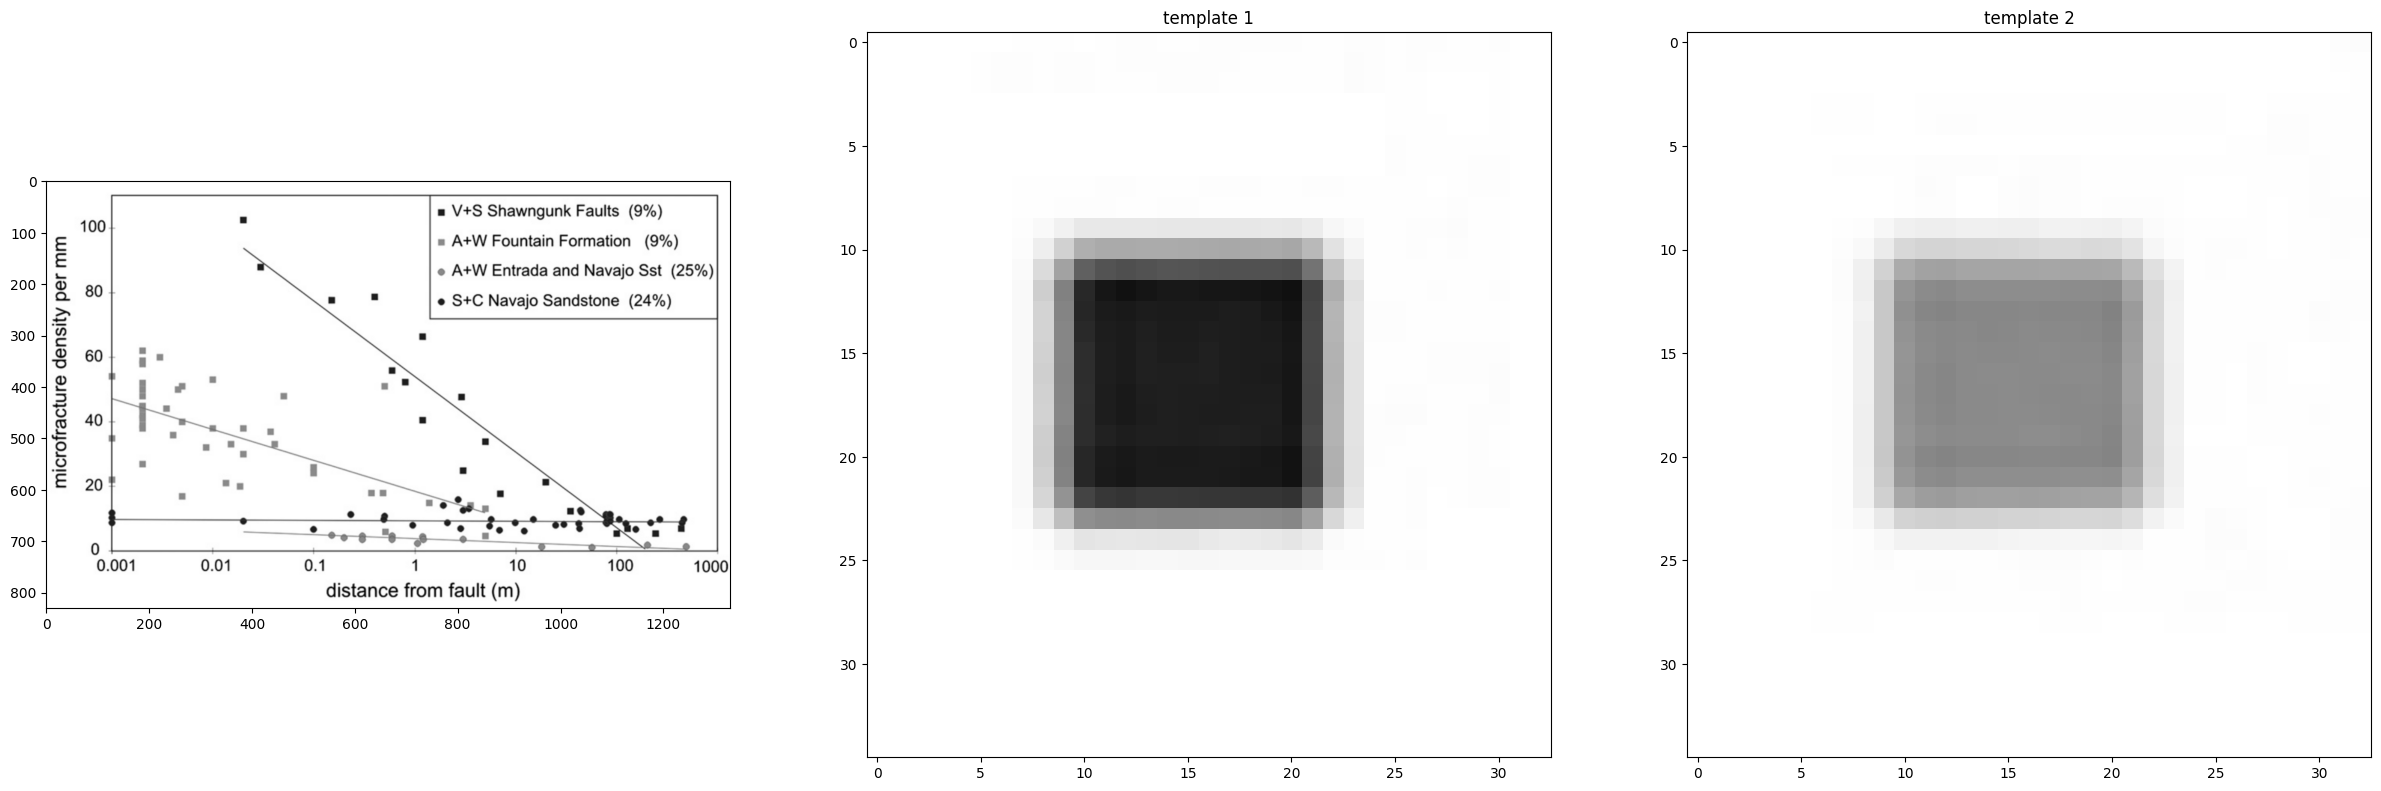

In [10]:
plt.figure(figsize=(30, 20))
plt.subplot(1, 3, 1)
draw_image(source_image)

plt.subplot(1, 3, 2)
draw_image(templates[0])
plt.title("template 1")

plt.subplot(1, 3, 3)
draw_image(templates[1])
plt.title("template 2")

In [11]:
tresh = 230

masks = [template_tresholding(template, treshold=tresh) for template in templates]
image_tresholded = template_tresholding(image_rgb, treshold=tresh)

Text(0.5, 1.0, 'template 2')

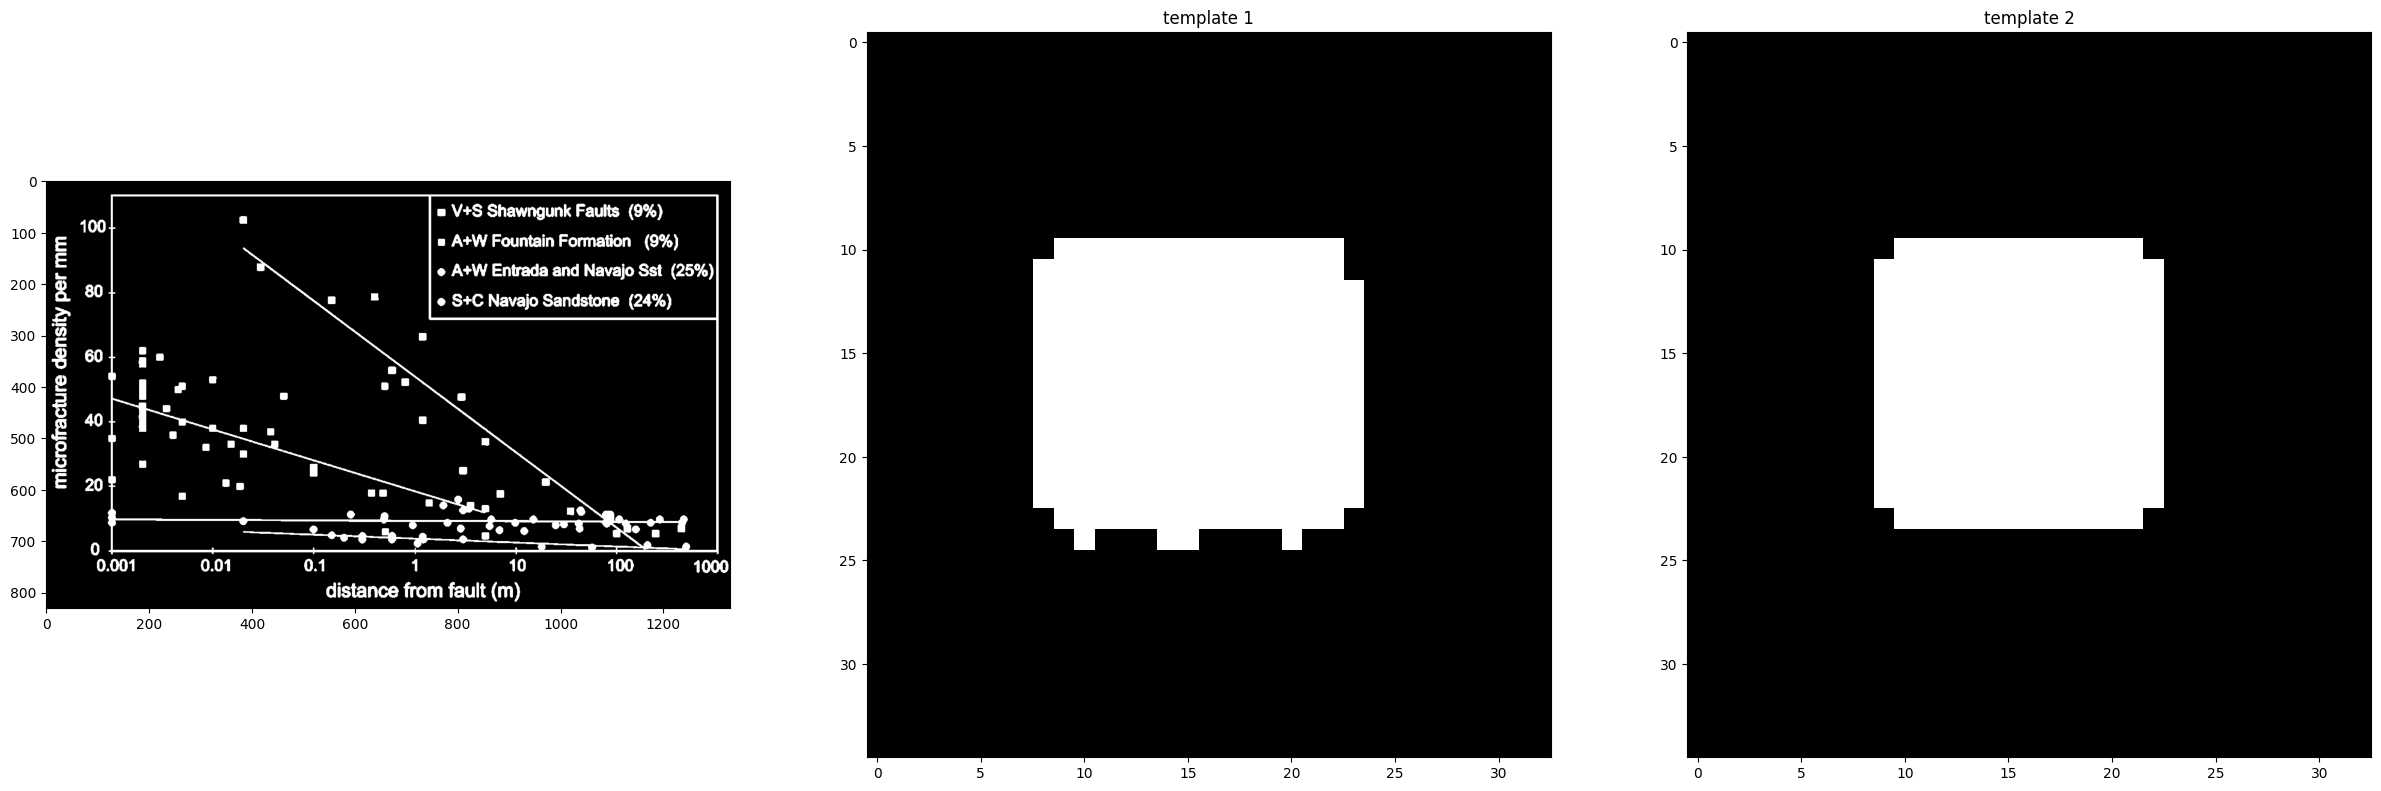

In [12]:
plt.figure(figsize=(30, 20))
plt.subplot(1, 3, 1)
draw_image(image_tresholded)

plt.subplot(1, 3, 2)
draw_image(masks[0])
plt.title("template 1")

plt.subplot(1, 3, 3)
draw_image(masks[1])
plt.title("template 2")

In [13]:
indexes_background = np.where(image_tresholded == 0)
image_rgb[indexes_background] = 0

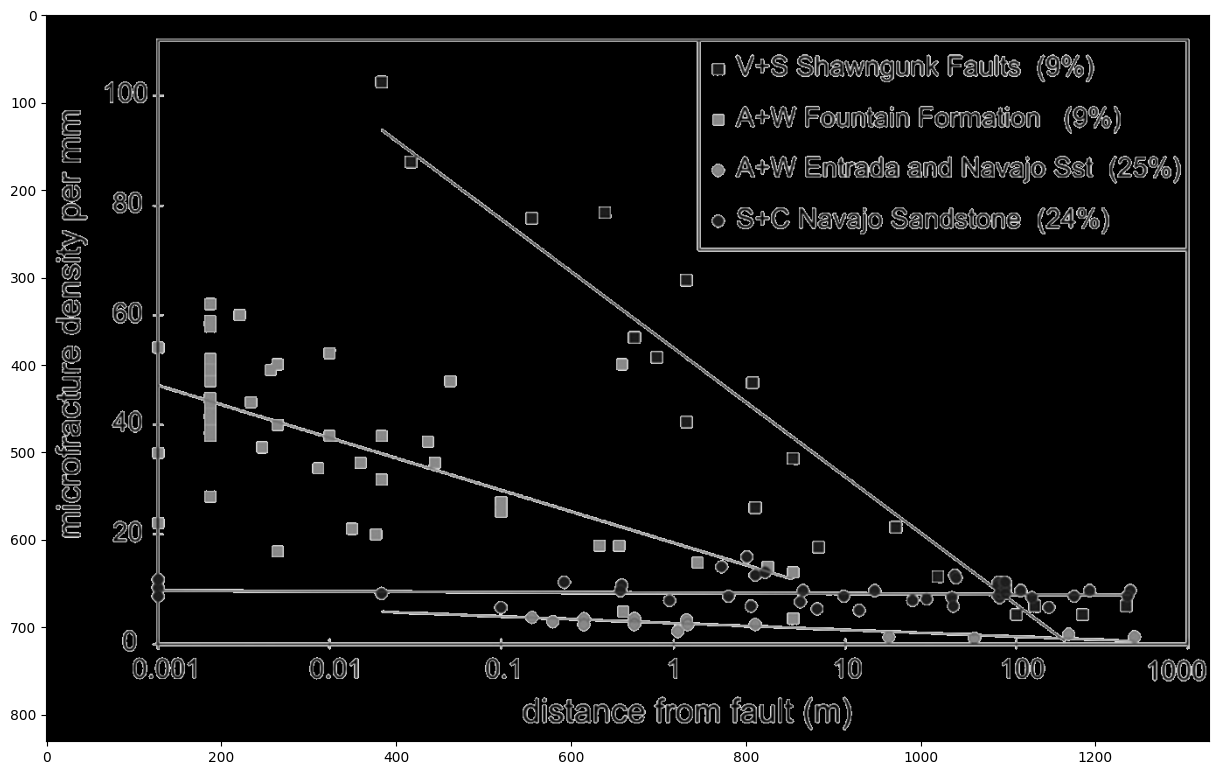

In [14]:
plt.figure(figsize=(15, 10))
draw_image(image_rgb)

In [15]:
%%time
# methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
#            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

method = 'cv.TM_CCORR_NORMED'
# method = 'cv.TM_SQDIFF_NORMED'

# method = 'cv.TM_CCOEFF_NORMED'
# method = 'cv.TM_SQDIFF'


convolution_map_list, max_val_list = multi_template_match(
    image_rgb, templates, masks, method_name=method
)

convolution_map_list = np.array(convolution_map_list)

CPU times: user 410 ms, sys: 4.07 ms, total: 414 ms
Wall time: 442 ms


In [16]:
for conv_map in convolution_map_list:
    nan_indexes = np.where( np.isnan(conv_map) )
    inf_indexes = np.where( np.isinf(conv_map) )
    conv_map[nan_indexes] = 0
    conv_map[inf_indexes] = 0


# imshow_interactive(convolution_map_list[0])

In [17]:
max_corr_map = np.max(convolution_map_list, axis=0)

best_match_map = get_best_matches(convolution_map_list)
np.unique(best_match_map, return_counts=True)

(array([0, 1, 2, 3]), array([370821, 256478, 257404, 149803]))

In [37]:
best_match_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 0, 1],
       ...,
       [1, 3, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 2, 2],
       [0, 0, 0, ..., 0, 0, 0]])

In [1]:
imshow_interactive(max_corr_map)

In [19]:
tolerance_limit = find_tolerance_limit(max_corr_map)
tolerance_limit

0.09

(987, 2)

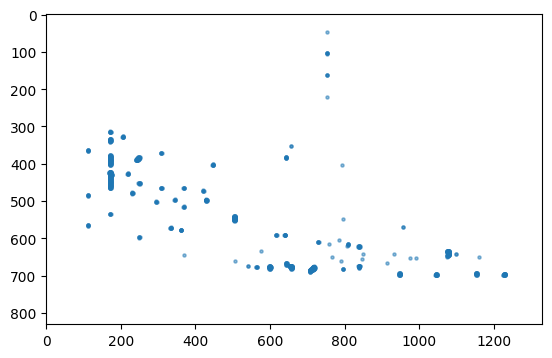

In [20]:
# run detection with limit tolerance value
max_val = np.max(max_corr_map)
points = detect_points(max_corr_map, max_val, tolerance=tolerance_limit)
draw_points_on_canvas(points, source_image)
points.shape

In [21]:
MARKER_NUMBERS

array([1, 2, 3, 4])

In [24]:
TEMPLATE_NUMBERS = MARKER_NUMBERS - 1

MARKER_COLORS = ["yellow", "blue", "orange", "red"]

In [25]:
# new approach, multiple markers

@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=20, step=0.1))
def visualize(tolerance, eps):


    plt.figure(figsize=(10, 6))
    draw_image(source_image)

    for template_number, color in zip(TEMPLATE_NUMBERS, MARKER_COLORS):
        points = detect_points_v2(max_corr_map, max_val, tolerance, best_match_map, template_number)

        # cluster_labels = meanshift_clustering(points, eps)
        cluster_labels = agglomerative_clustering(points, eps)
        actual_points = simplify_points(points, cluster_labels)
        x = actual_points[:, 0]
        y = actual_points[:, 1]


        x += w // 2 - 1
        y += h // 2 - 1
        plt.scatter(x, y, s=5, c=color, marker="*")
        plt.xticks([]); plt.yticks([]);
        plt.title(f"tolerance = {tolerance}")

    plt.show()
    
    # ## founded points on clear canvas
    # plt.figure(figsize=(10, 6))
    # draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.09, min=0.001, step=0.001), Floa…

In [27]:
# classic approach, single marker


@interact(tolerance=widgets.FloatSlider(value=0.001, min=0.001, max=tolerance_limit, step=0.001),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=20, step=0.1))
def visualize(tolerance, eps):

    points = detect_points(max_corr_map, max_val, tolerance=tolerance)

    # cluster_labels = meanshift_clustering(points, eps)
    cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=5, c="yellow", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.title(f"tolerance = {tolerance}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.001, description='tolerance', max=0.09, min=0.001, step=0.001), Floa…

In [ ]:
def draw_markers(points: np.ndarray, best_match_map: np.ndarray) -> None:
    """
    points.shape = (n, 2)
    """
    unique_labels = np.unique(best_match_map)

    for label in unique_labels:
        label_points_indexes = np.where(best_match_map == label)


In [26]:
a = np.array([1, 0, 0.99, 0.98, 0.9899999])

In [27]:
a / np.max(a)

array([1.       , 0.       , 0.99     , 0.98     , 0.9899999])

## NMS

https://github.com/amusi/Non-Maximum-Suppression/tree/master

In [1]:
def nms(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score

In [2]:
# bounding_boxes = [(187, 82, 337, 317), (150, 67, 305, 282), (246, 121, 368, 304)]
# confidence_score = [0.9, 0.75, 0.8]



In [58]:
# IoU threshold
threshold = 0.9

In [59]:
tolerance = 0.02
points = detect_points(max_corr_map, max_val, tolerance=tolerance)

In [60]:
bboxes = []
scores = []

for point in points:
    bbox = point_to_bbox(*point[::-1], w, h, max_corr_map)
    bboxes.append(bbox)
    scores.append(max_corr_map[point[1], point[0]])

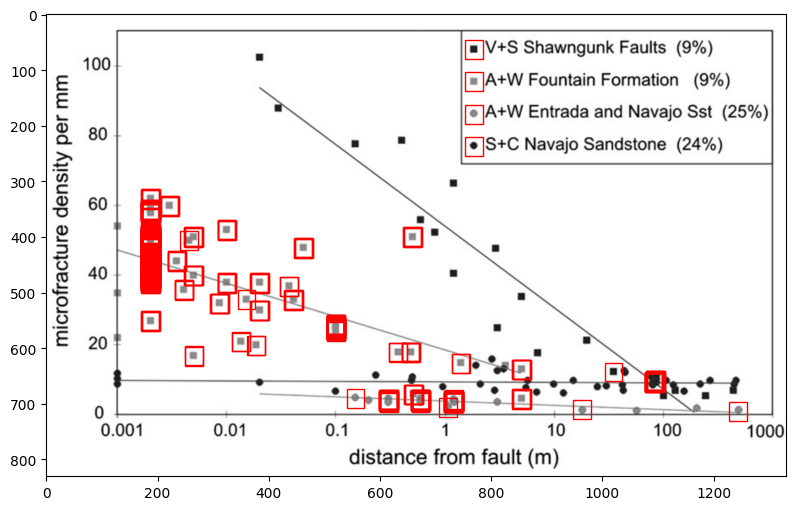

In [61]:
## founded points on original image
plt.figure(figsize=(10, 6))
draw_image(source_image)

for bbox in bboxes:
    draw_bbox(*bbox)
    
plt.show()

In [62]:
bboxes_nms, scores_mns = nms(bboxes, scores, threshold)

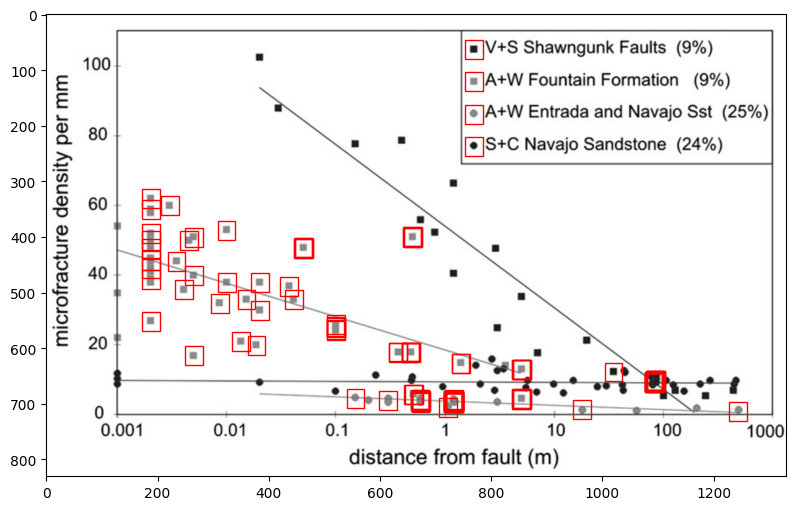

In [63]:
## founded points on original image
plt.figure(figsize=(10, 6))
draw_image(source_image)

for bbox in bboxes_nms:
    draw_bbox(*bbox)
    
plt.show()